# Web Scraping

In [1]:
# pip install selenium

In [2]:
#pip install lxml

In [3]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

import datetime
import os
import requests
from tqdm.notebook import tqdm

# Collect Southbound Shareholding CCASS Data

In [4]:
URL = "https://www3.hkexnews.hk/sdw/search/mutualmarket.aspx?t=hk"
print(URL)

n = 0   # init counter
start_date = '2025/12/01' # must not be earlier than one year
end_date = '2025/12/31' # input one day after end day

rec_num = 0
total_days = (datetime.datetime.strptime(end_date,'%Y/%m/%d')-datetime.datetime.strptime(start_date,'%Y/%m/%d')).days

df_sh = pd.DataFrame()

for d in tqdm(range(total_days)):
    datetime.timedelta(days=n)
    search_date = (datetime.datetime.strptime(start_date,'%Y/%m/%d')+datetime.timedelta(days=n)).strftime('%Y/%m/%d')
    
    with requests.Session() as s:
        s.headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        res = s.get(URL)
        soup = BeautifulSoup(res.text,"lxml")
        payload = {item['name']:item.get('value','') for item in soup.select("input[name]")}
        payload['__EVENTTARGET'] = 'btnSearch'    
        payload['txtShareholdingDate'] = search_date   
        req = s.post(URL, data=payload, headers={"User-Agent":"Mozilla/5.0"})    
        soup_result = BeautifulSoup(req.text,"lxml")

    # if serach date is the record date
    if soup_result.find('h2', {'class':"ccass-heading"}).find('span').text.split(': ')[1] == search_date:   
        rec_num += 1
        ticker, name, shares, pct = [],[],[],[]
        
        for items in soup_result.select("table tbody tr"): 
            data = [item.get_text(strip=True) for item in items.select("td")]

            if data[0].split(':')[1] in ['700','941','883','939','2020']:
                ticker.append(data[0].split(':')[1])
                name.append(data[1].split(':')[1])
                try:
                    shares.append( int( data[2].split(':')[1].replace(',','') ) )
                except:
                    shares.append(np.nan)
                try:
                    pct.append(float(data[3].split(':')[1].replace('%',''))/100)
                except:
                    pct.append(np.nan)
            
        df_temp = pd.DataFrame(data={'Date':search_date,
                                     'StockCode':ticker,
                                     'StockName':name,
                                     'SB_ShareHolding':shares,
                                     'HoldingRatio':pct,
                                      } )    
        if len(df_sh)==0: df_sh = df_temp
        else: df_sh = pd.concat([df_sh, df_temp] , ignore_index=True)
           
    n+=1
    if search_date==end_date: break

df_sh = df_sh.set_index('Date') 
df_sh.index = pd.to_datetime(df_sh.index) 


print(f'Total {rec_num} days records found from {start_date} to {end_date}.' )

https://www3.hkexnews.hk/sdw/search/mutualmarket.aspx?t=hk


  0%|          | 0/30 [00:00<?, ?it/s]

Total 24 days records found from 2025/12/01 to 2025/12/31.


In [5]:
ticker_map = {'700':'0700.HK',
             '941':'0941.HK',
             '939':'0939.HK',
             '883':'0883.HK',
             '2020':'2020.HK',}
df_sh.StockCode = df_sh.StockCode.map(ticker_map)
df_sh

,StockCode,StockName,SB_ShareHolding,HoldingRatio
Date,,,,
2025-12-01,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1013801007,0.1108
2025-12-01,0883.HK,CNOOC LIMITED -HKD TRADED SHARES,10250838572,0.2156
2025-12-01,0939.HK,CHINA CONSTRUCTION BANK CORPORATION,34002384896,0.1414
2025-12-01,0941.HK,CHINA MOBILE LIMITED -HKD TRADED SHARES,3104889233,0.1435
2025-12-01,2020.HK,ANTA SPORTS PRODUCTS LIMITED -HKD TRADED SHARES,226511831,0.0806
...,...,...,...,...
2025-12-30,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1005257196,0.1100
2025-12-30,0883.HK,CNOOC LIMITED -HKD TRADED SHARES,10207861878,0.2146
2025-12-30,0939.HK,CHINA CONSTRUCTION BANK CORPORATION,33825303476,0.1406


In [6]:
df_sh.loc[df_sh.StockCode=='0700.HK']

,StockCode,StockName,SB_ShareHolding,HoldingRatio
Date,,,,
2025-12-01,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1013801007,0.1108
2025-12-02,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1014230467,0.1108
2025-12-03,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1014381139,0.1108
2025-12-04,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1013762230,0.1107
2025-12-05,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1012561239,0.1106
2025-12-06,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1012561239,0.1106
2025-12-08,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1010340694,0.1103
2025-12-09,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1007961768,0.1101
2025-12-10,0700.HK,TENCENT HOLDINGS LIMITED -HKD TRADED SHARES,1006702734,0.1100


<Axes: xlabel='Date'>

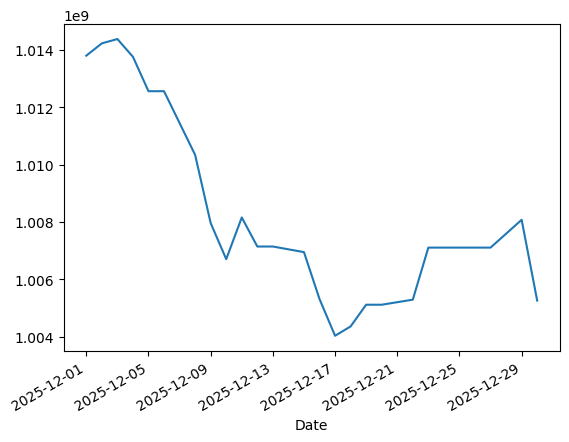

In [7]:
df_sh.loc[df_sh.StockCode=='0700.HK', 'SB_ShareHolding'].plot()

<Axes: xlabel='Date'>

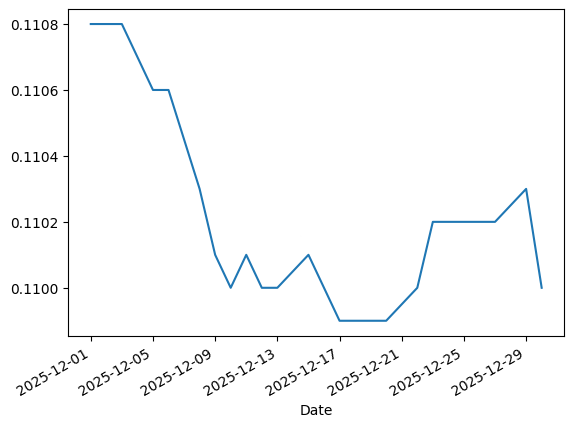

In [8]:
df_sh.loc[df_sh.StockCode=='0700.HK', 'HoldingRatio'].plot()

# CCASS Concentration
https://www3.hkexnews.hk/sdw/search/searchsdw.aspx

In [9]:
%%time

URL = "https://www3.hkexnews.hk/sdw/search/searchsdw.aspx"
tickers = ['00700','00941','00883','00939','02020']
df_concen = pd.DataFrame()

for ticker in tickers:
    n = 0   # init counter
    start_date = '20251201'
    end_date = '20251231'
    rec_num = 0
    total_days = (datetime.datetime.strptime(end_date,'%Y%m%d')-datetime.datetime.strptime(start_date,'%Y%m%d')).days
    
    df = pd.DataFrame()
    df_concen_ = pd.DataFrame()
    for d in tqdm(range(total_days), desc=f'Extracting {ticker}'):
        
        search_date = (datetime.datetime.strptime(start_date,'%Y%m%d')+datetime.timedelta(days=n)).strftime('%Y%m%d')
        
        with requests.Session() as s:
            s.headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
            res = s.get(URL)
            soup = BeautifulSoup(res.text,"lxml")
            payload = {item['name']:item.get('value','') for item in soup.select("input[name]")}
            payload['__EVENTTARGET'] = 'btnSearch'
            payload['txtShareholdingDate'] = search_date
            payload['txtStockCode'] = ticker
            req = s.post(URL,data=payload,headers={"User-Agent":"Mozilla/5.0"})    
            soup_obj = BeautifulSoup(req.text,"lxml")
            martketShares = int(soup_obj.find('div',{'class':"ccass-search-datarow"}).find('div',{'class':"value"}).text.replace(',',''))
            
        # if serach date is the record date
        if soup_obj.find('input',type='text').get('value') == datetime.datetime.strptime(search_date,'%Y%m%d').strftime('%Y/%m/%d'):
            rec_num += 1
            id, name, shares, pct, mks = [],[],[],[],[]
            for ctr, items in enumerate(soup_obj.select("table tbody tr")): 
                data = [item.get_text(strip=True) for item in items.select("td")]
                id.append(data[0].split(':')[1])
                name.append(data[1].split(':')[1])
                shares.append(int(data[3].split(':')[1].replace(',','')))
                pct.append(float(data[4].split(':')[1].replace('%',''))/100)
                mks.append(martketShares)
                if ctr==4: break    # Extract top  5 shareholding
        
            df_temp = pd.DataFrame(data={'Date':search_date,
                                         'ParticipantID':id,
                                         'Name':name,
                                         'ShareHolding':shares,
                                         'OwnedRatio':pct,
                                         'MarketShares':mks } )    
            if len(df)==0: df = df_temp
            else: df = pd.concat([df, df_temp] , ignore_index=True)
               
        n+=1
        if search_date==end_date: break

    df_concen_['Top5_Concen'] = df.groupby('Date')['ShareHolding'].apply(np.sum) / df.groupby('Date')['MarketShares'].apply(lambda x:x.iloc[0])
    df_concen_['Date'] = df['Date'].unique()
    df_concen_['Ticker'] = ticker
    
    if len(df_concen)==0: df_concen = df_concen_
    else: df_concen = pd.concat([df_concen, df_concen_] , ignore_index=True)
    
    print(f'Total {rec_num} days records found from {start_date} to {end_date}.' )

Extracting 00700:   0%|          | 0/30 [00:00<?, ?it/s]

Total 24 days records found from 20251201 to 20251231.


Extracting 00941:   0%|          | 0/30 [00:00<?, ?it/s]

Total 24 days records found from 20251201 to 20251231.


Extracting 00883:   0%|          | 0/30 [00:00<?, ?it/s]

Total 24 days records found from 20251201 to 20251231.


Extracting 00939:   0%|          | 0/30 [00:00<?, ?it/s]

Total 24 days records found from 20251201 to 20251231.


Extracting 02020:   0%|          | 0/30 [00:00<?, ?it/s]

Total 24 days records found from 20251201 to 20251231.
CPU times: user 21.6 s, sys: 649 ms, total: 22.3 s
Wall time: 45min 53s


In [10]:
ticker_map2 = {'00700':'0700.HK',
               '00941':'0941.HK',
               '00939':'0939.HK',
               '00883':'0883.HK',
               '02020':'2020.HK',}
df_concen.index = pd.to_datetime(df_concen['Date'])
df_concen.Ticker = df_concen.Ticker.map(ticker_map2)
df_concen = df_concen.drop('Date', axis=1)
df_concen

,Top5_Concen,Ticker
Date,,
2025-12-01,0.731866,0700.HK
2025-12-02,0.731964,0700.HK
2025-12-03,0.731934,0700.HK
2025-12-04,0.731728,0700.HK
2025-12-05,0.731597,0700.HK
...,...,...
2025-12-23,0.805625,2020.HK
2025-12-24,0.805625,2020.HK
2025-12-27,0.805625,2020.HK


<Axes: xlabel='Date'>

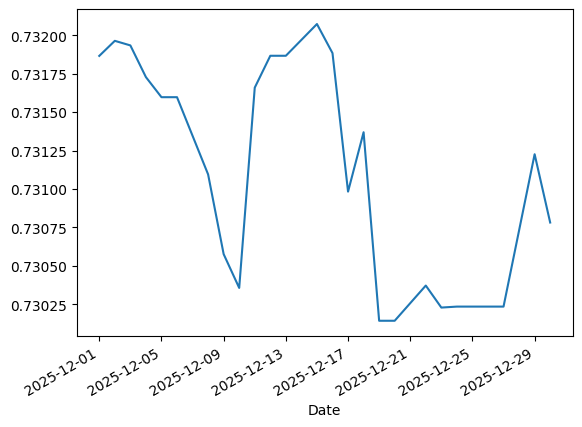

In [11]:
df_concen.loc[df_concen.Ticker=='0700.HK', 'Top5_Concen'].plot()

<Axes: xlabel='Date'>

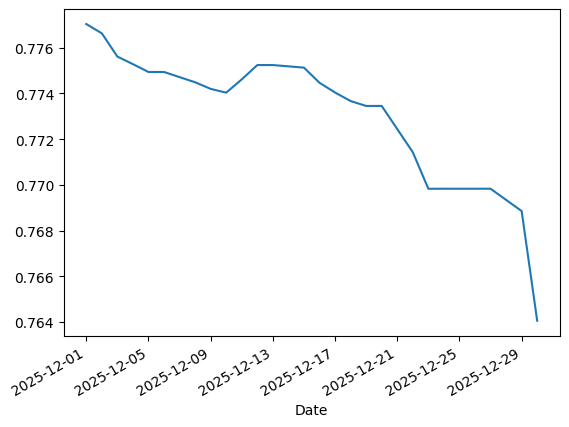

In [15]:
df_concen.loc[df_concen.Ticker=='0941.HK', 'Top5_Concen'].plot()

# Web Scraping data using Selenium
https://www.investing.com/currencies/usd-hkd-historical-data

In [23]:
options = Options()
options.set_preference("general.useragent.override", "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3")
#options.headless = True

driver = webdriver.Firefox(options=options)

driver.get("https://www.investing.com/currencies/usd-hkd-historical-data")

In [24]:
from bs4 import BeautifulSoup
import pandas as pd

page_source = driver.page_source.encode('utf-8')

# Decode page source to string
page_source = page_source.decode('utf-8')

soup = BeautifulSoup(page_source, 'html.parser')

# Find the table
tables = soup.find_all('table')

# print(len(tables))

# Initialize a list to store your data
data = []

# Extract and store the table headers
headers = []

table= tables[1]

for th in table.find('thead').find_all('th'):
    headers.append(th.text.strip())
data.append(headers)

# Loop through each row in the third table
for row in table.find('tbody').find_all('tr'):
    # Extract text from each cell in the row
    cells = row.find_all('td')
    row_data = [cell.text.strip() for cell in cells]
    if row_data:
        data.append(row_data)

driver.close()

NoSuchWindowException: Message: Browsing context has been discarded
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:202:5
NoSuchWindowError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:782:5
assert.that/<@chrome://remote/content/shared/webdriver/Assert.sys.mjs:581:13
assert.open@chrome://remote/content/shared/webdriver/Assert.sys.mjs:169:4
GeckoDriver.prototype.getPageSource@chrome://remote/content/marionette/driver.sys.mjs:1254:15
dispatch@chrome://remote/content/marionette/server.sys.mjs:318:40
execute@chrome://remote/content/marionette/server.sys.mjs:289:16
onPacket/<@chrome://remote/content/marionette/server.sys.mjs:262:20
onPacket@chrome://remote/content/marionette/server.sys.mjs:263:9
_onJSONObjectReady/<@chrome://remote/content/marionette/transport.sys.mjs:494:20


In [14]:
pd.DataFrame(data[1:], columns=data[0])

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jan 05, 2026",7.7871,7.7908,7.7938,7.7868,,-0.05%
1,"Jan 04, 2026",7.7908,7.7908,7.7919,7.7905,,-0.01%
2,"Jan 02, 2026",7.7912,7.7843,7.7933,7.7840,,+0.09%
3,"Jan 01, 2026",7.7844,7.7829,7.7845,7.7823,,+0.02%
4,"Dec 31, 2025",7.7829,7.7808,7.7852,7.7804,,+0.02%
5,"Dec 30, 2025",7.7810,7.7740,7.7846,7.7730,,+0.09%
6,"Dec 29, 2025",7.7739,7.7714,7.7751,7.7705,,+0.03%
7,"Dec 26, 2025",7.7714,7.7750,7.7760,7.7704,,-0.05%
8,"Dec 25, 2025",7.7753,7.7754,7.7763,7.7744,,0.00%
9,"Dec 24, 2025",7.7753,7.7777,7.7781,7.7740,,-0.03%
